neccessary imports, selecting the compute device, setting seed, data loading and visualization

using compute device: cpu
shape of the dataset:  (36380, 9)


FileNotFoundError: [Errno 2] No such file or directory: '/home/ahmad_rahmani/catkin_ws/src/sorosimpp_bayopt_throw/scripts/datasets/amprs_10hz_36k_plots/x_y_z plot.png'

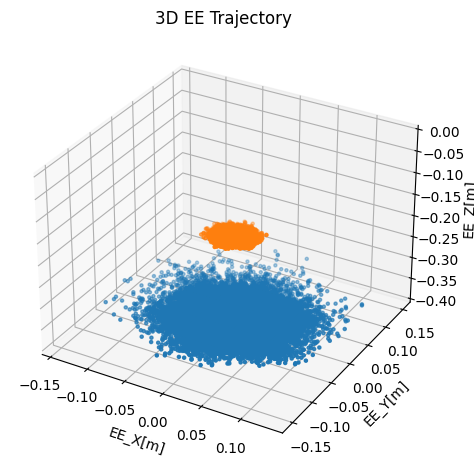

In [ ]:
# setting the seeds 
import numpy as np 
import matplotlib.pyplot as plt 
import os 
import random 
import torch 
import pandas as pd  

##  user inputs ## 
# names and directories 
dataset_dir_name = "datasets"
dataset_filename = "amprs_10hz_36k.csv" 
data_plot_dir_name = "amprs_10hz_36k_plots" 
# determining the indices to reference the dataset  
input_1_index = 0 
input_2_index = 1 
input_3_index = 2 
midsection_x_index = 3 
midsection_y_index = 4 
midsection_z_index = 5 
ee_x_index = 6 
ee_y_index = 7 
ee_z_index = 8 
input_start_index = 0  
input_stop_index = 3 
state_start_index = 3 
state_stop_index = 9 

# selecting the compute device 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 
print(f"using compute device: {device}") 
if device.type == "cuda":
    print(f"GPU: {torch.cuda.get_device_name(0)}")  

# setting the seeds 
def set_all_seeds(seed: int = 42):
    """
    sets the seeds for python, numpy, and pytoch (CPU & GPU) 
    """
    # python random module
    random.seed(seed)
    # numpy
    np.random.seed(seed)
    # pytorch
    torch.manual_seed(seed)
    # pytorch (GPU)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
    print(f"Seeds set to {seed}") 

# setting up directory paths and loading the dataset
script_directory = os.path.dirname(os.path.abspath(__file__)) if "__file__" in globals() else os.getcwd() 
dataset_path = os.path.join(script_directory, dataset_dir_name) 
def load_data(file_path: str): 
    """
    Reads a csv and returns a numpy array of all the data 
    SETS THE INDEX TO THE TIME COLUMN
    """
    df = pd.read_csv(file_path) 
    df.set_index('time',inplace=True)  
    data = df.to_numpy() 
    return data   
dataset = load_data(os.path.join(dataset_path, dataset_filename)) 
print("shape of the dataset: ", dataset.shape)  

# data plot directory 
data_plot_path = os.path.join(dataset_path, data_plot_dir_name) 
os.makedirs(data_plot_path, exist_ok=True) 

# plotting  
# 3d trajectory plot 
plot_name = "x_y_z plot.png"  
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(dataset[:, ee_x_index], dataset[:, ee_y_index], dataset[:, ee_z_index], s=5)
ax.scatter(dataset[:, midsection_x_index], dataset[:, midsection_y_index], dataset[:, midsection_z_index], s=5)
ax.set_zlim(-0.4, 0)
ax.set_xlabel('EE_X[m]')
ax.set_ylabel('EE_Y[m]')
ax.set_zlabel('EE_Z[m]')
ax.set_title('3D EE Trajectory')
fig.tight_layout()
fig.savefig(os.path.join(data_plot_path, plot_name), dpi=300, bbox_inches="tight")
plt.close() 
# 3d ee trajectory plot 
plot_name = "ee_x_y_z plot.png"  
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(dataset[:, ee_x_index], dataset[:, ee_y_index], dataset[:, ee_z_index], s=5)
ax.set_zlim(-0.4, 0)
ax.set_xlabel('EE_X[m]')
ax.set_ylabel('EE_Y[m]')
ax.set_zlabel('EE_Z[m]')
ax.set_title('3D EE Trajectory')
fig.tight_layout()
fig.savefig(os.path.join(data_plot_path, plot_name), dpi=300, bbox_inches="tight")
plt.close() 
# 2d ee trajectory plot 
plot_name = "ee_x_y_plot.png"  
plt.figure()
plt.scatter(dataset[:,ee_x_index],dataset[:,ee_y_index], s=5)
plt.xlabel('EE_x[m]') 
plt.ylabel('EE_y[m]') 
plt.title('2D EE Trajectory')  
plt.tight_layout()  
plt.savefig(os.path.join(data_plot_path, plot_name), dpi=300, bbox_inches="tight") 
plt.close()  
# actuator inputs plots 
for i in range(input_stop_index) : 
    plot_name = f"u{i+1}_plot.png"   
    plt.figure()
    plt.plot(dataset[:,i])  
    plt.xlabel('Sample') 
    plt.ylabel(f"Actuator {i+1} Value") 
    plt.title(f"Actuator {i+1} Inputs")  
    plt.tight_layout()  
    plt.savefig(os.path.join(data_plot_path, plot_name), dpi=300, bbox_inches="tight") 
    plt.close()  
# state plots 
for i in range(state_start_index,state_stop_index) : 
    plot_name = f"x_{i+1}_plot.png"   
    plt.figure()
    plt.plot(dataset[:,i])  
    plt.xlabel('Sample') 
    plt.ylabel(f"State {i+1} Value") 
    plt.title(f"State {i+1} Values")  
    plt.tight_layout()  
    plt.savefig(os.path.join(data_plot_path, plot_name), dpi=300, bbox_inches="tight") 
    plt.close()